 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-780.323, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-778.566, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-776.664, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-777.610, Time=0.20 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-775.616, Time=0.37 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-773.677, Time=0.33 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=-774.825, Time=0.49 sec
 ARIMA(0,1,7)(0,0,0)[0] intercept   : AIC=-786.213, Time=0.61 sec
 ARIMA(0,1,8)(0,0,0)[0] intercept   : AIC=-788.144, Time=0.86 sec
 ARIMA(0,1,9)(0,0,0)[0] intercept   : AIC=-788.023, Time=1.14 sec
 ARIMA(0,1,10)(0,0,0)[0] intercept   : AIC=-786.866, Time=1.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-778.554, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-776.576, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-775.663, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-772.678, Time=0.38 sec
 ARIMA(1,

/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


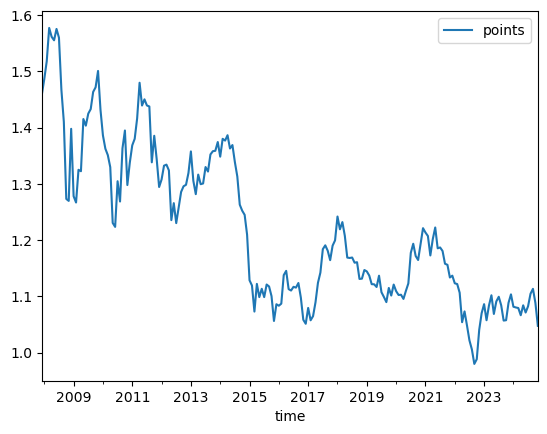

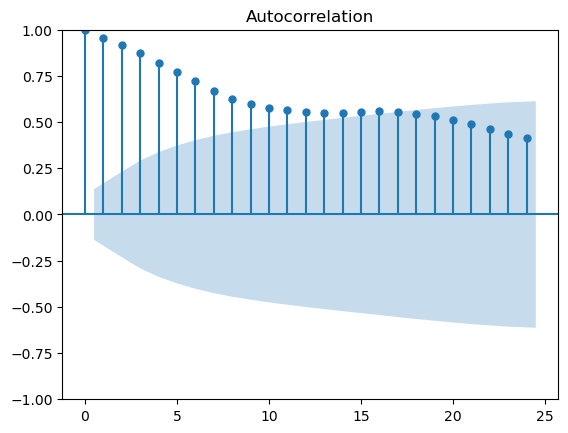

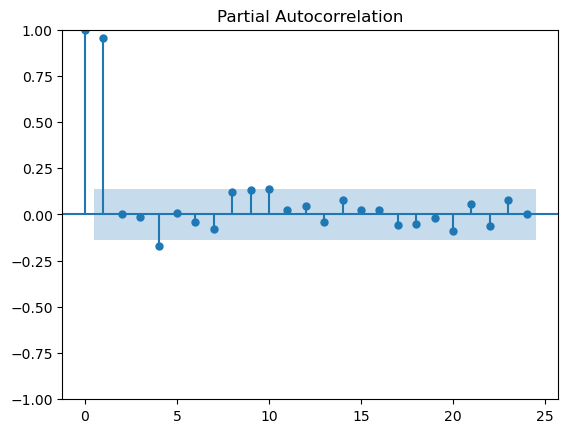

In [1]:
# use a library to do everything automatically, so that we can compare our results to

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
import numpy as np
import pmdarima as pm


# Load the CSV file
data = pd.read_csv('../data/EUR_USD_monthly.csv')

# Extract the time and price series
time = pd.to_datetime(data.iloc[:, 0])  # Assuming first column is 'time'
prices = data.iloc[:, 1].replace(',', '', regex=True).astype(float)  # Remove commas and convert to float


# Create a DataFrame with the time and prices
time_series_df = pd.DataFrame({'time': time, 'points': prices})
time_series_df.set_index('time', inplace=True)

def plot_series(series):
    # Plot the time series using Plotly
    series.plot()
    
    plot_acf(series)
    plot_pacf(series)
plot_series(time_series_df)




# Automatically fit the best ARIMA/SARIMA model
model = pm.auto_arima(
    time_series_df,
    seasonal=False,      # Enable seasonal differencing if necessary
    stepwise=False,      # Use stepwise algorithm for faster computation
    trace=True,         # Show the fitting process details
    #error_action='ignore',  # Ignore if the model doesn't fit properly
    #suppress_warnings=True  # Suppress warnings
    max_p=10,              # Set maximum p value to control AR component
    max_q=10,              # Set maximum q value to control MA component
    max_d=1,              # Set maximum differencing order
    max_P=1,              # Set maximum seasonal AR order
    max_Q=1,              # Set maximum seasonal MA order
    max_D=1,
    max_order = 10000
)


# Summary of the best model found
print(model.summary())

# Predict future values (e.g., next 12 periods)
forecast = model.predict(n_periods=12)
print(forecast)



Test stationarity, Augmented Dickey-Fuller unit root test.

In [2]:
#Check stationarity
# alternative hypothesis is stationarity 
st.adfuller(time_series_df['points'])


(-0.8833017572640469,
 0.7934216416235764,
 9,
 194,
 {'1%': -3.4645146202692527,
  '5%': -2.8765564361715534,
  '10%': -2.5747745328940375},
 -717.875322423628)

p value > 0.05 => we can not conclude stationarity

apply box cox transformation, and use scipy to estimate optimal box cox parameter lambda (todo explain what method scipy uses)

Optimal lambda:  -2.3018585777936003


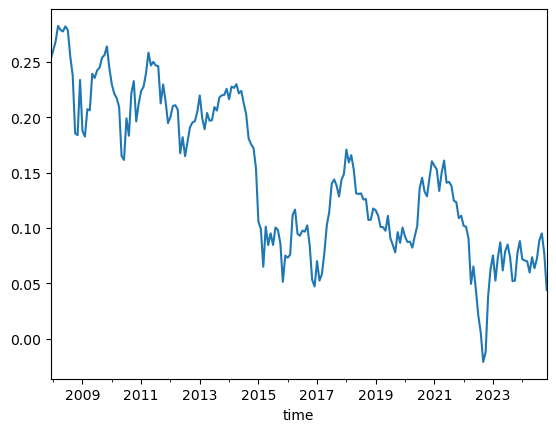

In [3]:
from scipy import stats


# Apply Box-Cox transformation and estimate lambda
transformed_prices, lambda_est = stats.boxcox(time_series_df["points"])

# Store the transformed values back into the DataFrame
time_series_df['boxcox_points'] = transformed_prices

time_series_df['boxcox_points'].plot()

print("Optimal lambda: ", lambda_est)

Differentiate and see when stationarity tests become positive

In [4]:
alpha = 0.05

        

# Assuming 'time_series_df' is your DataFrame and 'Prices' is the column
current_series = time_series_df['points'] # todo possible bug, try with_: pd.DataFrame(np.random.random(100))#np.exp(time_series_df['boxcox_points'])
differencing_count = 0

# Function to apply ADF test and get p-value
def get_adf_p_value(series):
    adf_result = st.adfuller(series.dropna())
    return adf_result[1]  # Return p-value from ADF test

# Keep iterating until the series is stationary or we reach the max differencing
while get_adf_p_value(current_series) >= alpha:
    differencing_count += 1
    # Apply first-order differencing
    current_series = current_series.diff()

    # Add the differenced series to the DataFrame
    time_series_df[f'diff_prices_{differencing_count}'] = current_series
    print("defferentiation")
    # Print progress with the p-value after differencing
    print(f"After {differencing_count} differencing(s), the ADF p-value is: {get_adf_p_value(current_series)}")


# Check if series is stationary after differencing
if get_adf_p_value(current_series) < alpha:
    print(f"Series is stationary after {differencing_count} differencings.")
    print("")
else:
    print("Max differencings reached without achieving stationarity.")





defferentiation
After 1 differencing(s), the ADF p-value is: 1.2426670145880777e-08
Series is stationary after 1 differencings.



Plot the new time series and acf and pcf

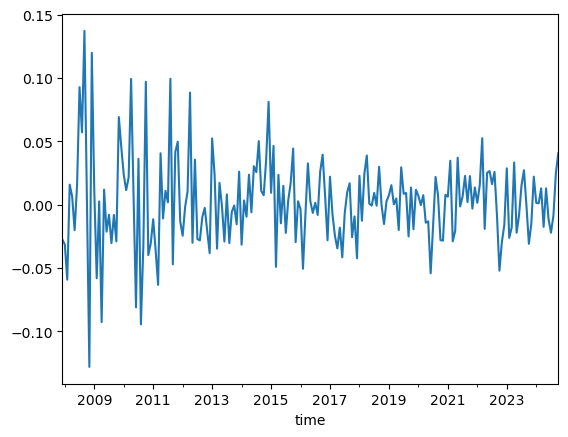

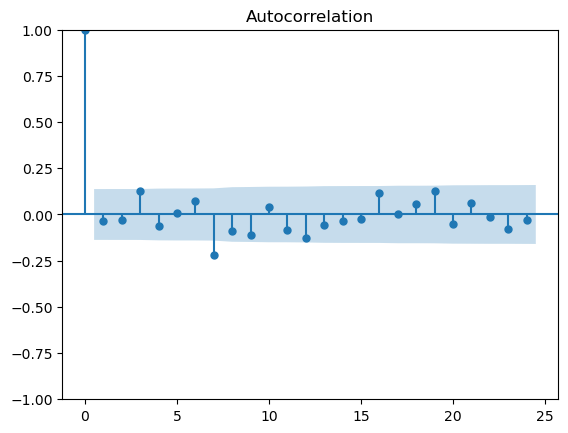

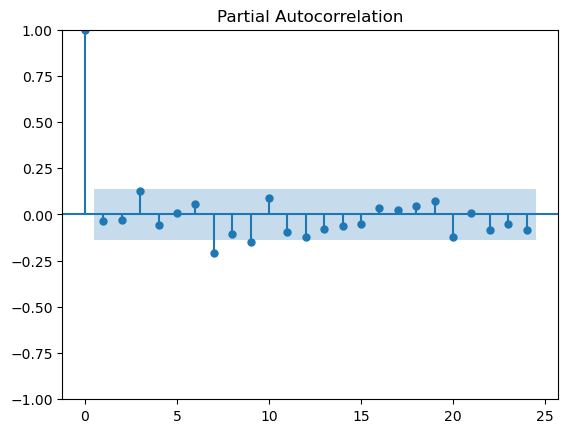

In [5]:
plot_series(time_series_df[f'diff_prices_{differencing_count}'].dropna())


Print significant auto and partial autocorelations

In [6]:
print(st.acf(time_series_df[f'diff_prices_{differencing_count}'].dropna(), qstat=True))

(array([ 1.        , -0.03365732, -0.02826342,  0.12864677, -0.06457575,
        0.00608376,  0.07312028, -0.22007495, -0.09050825, -0.10975887,
        0.04149674, -0.08338499, -0.12708712, -0.05490398, -0.03557711,
       -0.02422668,  0.11440957,  0.00193089,  0.05805922,  0.12820226,
       -0.05282868,  0.06202194, -0.01250253, -0.0767693 ]), array([ 0.23337674,  0.39876442,  3.84240378,  4.71444248,  4.72222158,
        5.85165179, 16.1350117 , 17.88321363, 20.46742119, 20.83871736,
       22.34575616, 25.86475895, 26.52500207, 26.8036972 , 26.9336183 ,
       29.84656821, 29.84740237, 30.60566648, 34.3229306 , 34.95758643,
       35.83715387, 35.87309297, 37.23564319]), array([0.62903125, 0.81923671, 0.27899224, 0.31787164, 0.45071202,
       0.44001183, 0.0239111 , 0.0221193 , 0.01523701, 0.0222467 ,
       0.02182736, 0.01121677, 0.01444139, 0.02041631, 0.02928188,
       0.01881423, 0.02746681, 0.03195811, 0.01682951, 0.02033133,
       0.022804  , 0.03133063, 0.03071251]))
